In [1]:
import pandas as pd
from tqdm import tqdm
import os
import librosa as lb
import numpy as np
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
import shutil
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers, optimizers

from scipy.signal import butter, lfilter
from scipy.signal import freqz

2.2.0


In [2]:
file_data = pd.read_csv('file_data.csv')

In [3]:
file_data

,fname,start,end,crack_wheez,fname_cycle,len
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav,0.543
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav,1.871
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav,1.443
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav,1.900
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav,1.728
...,...,...,...,...,...,...
6852,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,226_1b1_Pl_sc_LittC2SE_6.wav,1.972
6853,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,226_1b1_Pl_sc_LittC2SE_7.wav,1.843
6854,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,226_1b1_Pl_sc_LittC2SE_8.wav,1.957
6855,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,226_1b1_Pl_sc_LittC2SE_9.wav,1.943


In [4]:
# Split data into train and test sets
train_df, test_df = train_test_split(file_data, test_size=0.2, random_state=0)

<AxesSubplot:title={'center':'Count (target)'}>

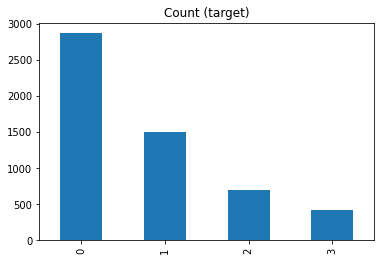

In [5]:
train_df.crack_wheez.value_counts().plot(kind='bar', title='Count (target)')

In [6]:
train_df

,fname,start,end,crack_wheez,fname_cycle,len
6349,213_1p3_Al_mc_AKGC417L,18.306,19.174,0,213_1p3_Al_mc_AKGC417L_6.wav,0.868
1551,133_2p2_Ar_mc_AKGC417L,0.137,2.554,0,133_2p2_Ar_mc_AKGC417L_0.wav,2.417
415,109_1b1_Pr_sc_Litt3200,21.131,22.752,0,109_1b1_Pr_sc_Litt3200_11.wav,1.621
4135,172_2b5_Tc_mc_AKGC417L,15.634,18.840,2,172_2b5_Tc_mc_AKGC417L_5.wav,3.206
4784,184_1b1_Ar_sc_Meditron,17.779,19.979,0,184_1b1_Ar_sc_Meditron_7.wav,2.200
...,...,...,...,...,...,...
4931,186_3b3_Al_mc_AKGC417L,4.958,8.542,0,186_3b3_Al_mc_AKGC417L_1.wav,3.584
3264,158_2p3_Lr_mc_AKGC417L,9.975,11.544,1,158_2p3_Lr_mc_AKGC417L_6.wav,1.569
1653,133_2p4_Tc_mc_AKGC417L,8.375,10.780,0,133_2p4_Tc_mc_AKGC417L_3.wav,2.405
2607,151_3p2_Ar_mc_AKGC417L,7.488,10.860,1,151_3p2_Ar_mc_AKGC417L_2.wav,3.372


<AxesSubplot:title={'center':'Count (target)'}>

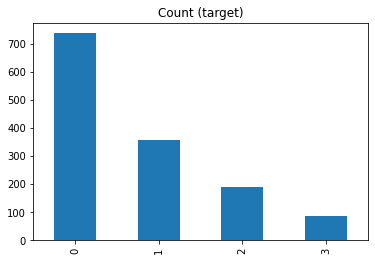

In [7]:
test_df.crack_wheez.value_counts().plot(kind='bar', title='Count (target)')

In [8]:
test_df

,fname,start,end,crack_wheez,fname_cycle,len
4963,186_3b3_Tc_mc_AKGC417L,11.911,15.387,0,186_3b3_Tc_mc_AKGC417L_3.wav,3.476
1668,133_3p2_Ar_mc_AKGC417L,4.661,7.423,2,133_3p2_Ar_mc_AKGC417L_2.wav,2.762
3578,163_8b3_Ar_mc_AKGC417L,13.613,16.337,0,163_8b3_Ar_mc_AKGC417L_4.wav,2.724
4501,178_1b2_Al_mc_AKGC417L,11.982,13.732,2,178_1b2_Al_mc_AKGC417L_8.wav,1.750
119,106_2b1_Pr_mc_LittC2SE,14.336,16.807,2,106_2b1_Pr_mc_LittC2SE_6.wav,2.471
...,...,...,...,...,...,...
1540,132_2b2_Lr_mc_LittC2SE,15.244,17.305,1,132_2b2_Lr_mc_LittC2SE_7.wav,2.061
2932,156_5b3_Ll_mc_AKGC417L,15.089,17.263,1,156_5b3_Ll_mc_AKGC417L_7.wav,2.174
1788,135_2b2_Tc_mc_LittC2SE,10.636,13.393,0,135_2b2_Tc_mc_LittC2SE_4.wav,2.757
2337,147_2b2_Al_mc_AKGC417L,8.364,12.794,2,147_2b2_Al_mc_AKGC417L_2.wav,4.430


In [9]:
#Reset index
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [10]:
train_df

,fname,start,end,crack_wheez,fname_cycle,len
0,213_1p3_Al_mc_AKGC417L,18.306,19.174,0,213_1p3_Al_mc_AKGC417L_6.wav,0.868
1,133_2p2_Ar_mc_AKGC417L,0.137,2.554,0,133_2p2_Ar_mc_AKGC417L_0.wav,2.417
2,109_1b1_Pr_sc_Litt3200,21.131,22.752,0,109_1b1_Pr_sc_Litt3200_11.wav,1.621
3,172_2b5_Tc_mc_AKGC417L,15.634,18.840,2,172_2b5_Tc_mc_AKGC417L_5.wav,3.206
4,184_1b1_Ar_sc_Meditron,17.779,19.979,0,184_1b1_Ar_sc_Meditron_7.wav,2.200
...,...,...,...,...,...,...
5480,186_3b3_Al_mc_AKGC417L,4.958,8.542,0,186_3b3_Al_mc_AKGC417L_1.wav,3.584
5481,158_2p3_Lr_mc_AKGC417L,9.975,11.544,1,158_2p3_Lr_mc_AKGC417L_6.wav,1.569
5482,133_2p4_Tc_mc_AKGC417L,8.375,10.780,0,133_2p4_Tc_mc_AKGC417L_3.wav,2.405
5483,151_3p2_Ar_mc_AKGC417L,7.488,10.860,1,151_3p2_Ar_mc_AKGC417L_2.wav,3.372


In [12]:
test_df[test_df.fname_cycle=='147_2b2_Al_mc_AKGC417L_2.wav']

,fname,start,end,crack_wheez,fname_cycle,len
1370,147_2b2_Al_mc_AKGC417L,8.364,12.794,2,147_2b2_Al_mc_AKGC417L_2.wav,4.43


In [10]:
test_df[test_df.crack_wheez==3]

,fname,start,end,crack_wheez,fname_cycle,len
7,156_2b3_Pl_mc_AKGC417L,2.0880,5.2480,3,156_2b3_Pl_mc_AKGC417L_0.wav,3.160
16,139_1b1_Ll_sc_Litt3200,1.9099,3.8871,3,139_1b1_Ll_sc_Litt3200_0.wav,1.977
33,107_3p2_Ar_mc_AKGC417L,12.0660,14.4700,3,107_3p2_Ar_mc_AKGC417L_5.wav,2.404
39,130_1p2_Al_mc_AKGC417L,5.1010,8.3390,3,130_1p2_Al_mc_AKGC417L_2.wav,3.238
46,180_1b4_Lr_mc_AKGC417L,15.5540,19.1080,3,180_1b4_Lr_mc_AKGC417L_4.wav,3.554
...,...,...,...,...,...,...
1301,192_2b2_Al_mc_LittC2SE,2.5640,5.0790,3,192_2b2_Al_mc_LittC2SE_1.wav,2.515
1304,160_1b3_Pr_mc_AKGC417L,9.7250,13.6140,3,160_1b3_Pr_mc_AKGC417L_2.wav,3.889
1330,107_3p2_Tc_mc_AKGC417L,12.0660,14.4700,3,107_3p2_Tc_mc_AKGC417L_5.wav,2.404
1348,141_1b3_Pr_mc_LittC2SE,19.3790,19.9500,3,141_1b3_Pr_mc_LittC2SE_5.wav,0.571


In [11]:
#Set maxpad length as 79 <--(Sampling rate*5s)/256(hop length)
def build_feat(df):
    X = []
    Y = []
    max_pad_len = 79
    for i in tqdm(range(len(df))):
        file = df.iloc[i].fname_cycle
        label = df.iloc[i].crack_wheez
        wav,  rate = lb.load('Breath_cycles/'+ file, sr=None)
        #limit the length of samples to only 6s (6*4000)
        if wav.shape[0] > 20000:
            wav = wav[0:20000]
        X_sample = lb.feature.mfcc(wav, sr=rate, n_fft=512,  win_length=400, n_mfcc=20, hop_length = 256, n_mels = 128, fmin = 100, fmax = 1800)
        pad_width = max_pad_len - X_sample.shape[1]
        X_sample = np.pad(X_sample, pad_width=((0, 0), (0, pad_width)), mode='constant')
        X.append(X_sample.T)
        Y.append(label)
    X, Y = np.array(X), np.array(Y)
    return X, Y

In [12]:
#Extract feature for testing data
X_val, y_val = build_feat(test_df)

100%|██████████| 1372/1372 [00:12<00:00, 109.47it/s]


In [13]:
X_, y_ = build_feat(train_df)

100%|██████████| 5485/5485 [00:48<00:00, 114.23it/s]


In [14]:
np.save('X_', X_)
np.save('y_', y_)
np.save('X_val', X_val)
np.save('y_val', y_val)

In [ ]:
X_ = np.load('X_.npy')
y_ = np.load('y_.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

In [16]:
X_.dtype

dtype('float32')

In [17]:
X_val.dtype

dtype('float32')

In [18]:
#Convert labels into one hot vectors
y_tr_cat= to_categorical(y_, num_classes=4)
y_val_cat= to_categorical(y_val, num_classes=4)

In [74]:
#define LSTM model with skip connection
def LSTM_net():
    N_CLASSES=4

    i = layers.Input(shape=(79, 20), name='input')
    x = layers.Masking()(i)
    x = layers.BatchNormalization(name='Batchr_norm')(x)
    s = layers.TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh')(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True),
                             name='bidirectional_lstm')(s)
    x = layers.concatenate([s, x], axis=2, name='skip_connection')
    x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = layers.MaxPooling1D(name='max_pool_1d')(x)
    x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.5, name='dropout')(x)
    x = layers.Dense(32, activation='relu',
                         activity_regularizer=regularizers.l2(0.001),
                         name='dense_3_relu')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)

    model = Model(inputs=i, outputs=o, name='long_short_term_memory')
    model.compile(optimizer= 'adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [75]:
LSTM_net().summary()

Model: "long_short_term_memory"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 79, 20)]     0                                            
__________________________________________________________________________________________________
masking_4 (Masking)             (None, 79, 20)       0           input[0][0]                      
__________________________________________________________________________________________________
Batchr_norm (BatchNormalization (None, 79, 20)       80          masking_4[0][0]                  
__________________________________________________________________________________________________
td_dense_tanh (TimeDistributed) (None, 79, 64)       1344        Batchr_norm[0][0]                
_____________________________________________________________________________

In [82]:
csv_path = os.path.join('logs', 'log_history_5s_batch22.csv')
model = LSTM_net()
#Save model checkpoints
cp = ModelCheckpoint('models/lstm_5s_batch22.h5', monitor='val_accuracy',  save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch', verbose=1)
csv_logger = CSVLogger(csv_path, append=False)

In [83]:
#Fit model
model.fit(X_,y_tr_cat, epochs = 150, workers = 4, batch_size = 64, validation_data=(X_val, y_val_cat), callbacks=[csv_logger, cp], verbose = True)


Epoch 1/150
84/86 [============================>.] - ETA: 0s - loss: 1.1084 - accuracy: 0.5298
Epoch 00001: val_accuracy improved from -inf to 0.55977, saving model to models/lstm_5s_batch22.h5
86/86 [==============================] - 3s 39ms/step - loss: 1.1095 - accuracy: 0.5291 - val_loss: 1.0431 - val_accuracy: 0.5598
Epoch 2/150
85/86 [============================>.] - ETA: 0s - loss: 1.0207 - accuracy: 0.5680
Epoch 00002: val_accuracy improved from 0.55977 to 0.57070, saving model to models/lstm_5s_batch22.h5
86/86 [==============================] - 1s 17ms/step - loss: 1.0202 - accuracy: 0.5681 - val_loss: 1.0109 - val_accuracy: 0.5707
Epoch 3/150
85/86 [============================>.] - ETA: 0s - loss: 0.9606 - accuracy: 0.5932
Epoch 00003: val_accuracy improved from 0.57070 to 0.60496, saving model to models/lstm_5s_batch22.h5
86/86 [==============================] - 1s 17ms/step - loss: 0.9609 - accuracy: 0.5936 - val_loss: 0.9756 - val_accuracy: 0.6050
Epoch 4/150
85/86 [===

Epoch 29/150
85/86 [============================>.] - ETA: 0s - loss: 0.1207 - accuracy: 0.9675
Epoch 00029: val_accuracy did not improve from 0.70044
86/86 [==============================] - 1s 16ms/step - loss: 0.1204 - accuracy: 0.9675 - val_loss: 1.2695 - val_accuracy: 0.6917
Epoch 30/150
85/86 [============================>.] - ETA: 0s - loss: 0.1074 - accuracy: 0.9726
Epoch 00030: val_accuracy did not improve from 0.70044
86/86 [==============================] - 1s 16ms/step - loss: 0.1085 - accuracy: 0.9725 - val_loss: 1.2725 - val_accuracy: 0.6968
Epoch 31/150
85/86 [============================>.] - ETA: 0s - loss: 0.0961 - accuracy: 0.9778
Epoch 00031: val_accuracy improved from 0.70044 to 0.70700, saving model to models/lstm_5s_batch22.h5
86/86 [==============================] - 1s 17ms/step - loss: 0.0959 - accuracy: 0.9779 - val_loss: 1.2325 - val_accuracy: 0.7070
Epoch 32/150
85/86 [============================>.] - ETA: 0s - loss: 0.0878 - accuracy: 0.9792
Epoch 00032: v

Epoch 58/150
85/86 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9811
Epoch 00058: val_accuracy did not improve from 0.71429
86/86 [==============================] - 1s 16ms/step - loss: 0.0741 - accuracy: 0.9812 - val_loss: 1.4238 - val_accuracy: 0.6647
Epoch 59/150
85/86 [============================>.] - ETA: 0s - loss: 0.0875 - accuracy: 0.9752
Epoch 00059: val_accuracy did not improve from 0.71429
86/86 [==============================] - 1s 16ms/step - loss: 0.0874 - accuracy: 0.9752 - val_loss: 1.5665 - val_accuracy: 0.6844
Epoch 60/150
84/86 [============================>.] - ETA: 0s - loss: 0.0760 - accuracy: 0.9812
Epoch 00060: val_accuracy did not improve from 0.71429
86/86 [==============================] - 1s 16ms/step - loss: 0.0755 - accuracy: 0.9814 - val_loss: 1.5317 - val_accuracy: 0.6676
Epoch 61/150
85/86 [============================>.] - ETA: 0s - loss: 0.0699 - accuracy: 0.9816
Epoch 00061: val_accuracy did not improve from 0.71429
86/86 

85/86 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9926
Epoch 00116: val_accuracy did not improve from 0.71429
86/86 [==============================] - 1s 17ms/step - loss: 0.0386 - accuracy: 0.9927 - val_loss: 1.6558 - val_accuracy: 0.6946
Epoch 117/150
85/86 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9904
Epoch 00117: val_accuracy did not improve from 0.71429
86/86 [==============================] - 1s 16ms/step - loss: 0.0442 - accuracy: 0.9903 - val_loss: 1.6034 - val_accuracy: 0.6771
Epoch 118/150
85/86 [============================>.] - ETA: 0s - loss: 0.0552 - accuracy: 0.9853
Epoch 00118: val_accuracy did not improve from 0.71429
86/86 [==============================] - 1s 17ms/step - loss: 0.0551 - accuracy: 0.9852 - val_loss: 1.7034 - val_accuracy: 0.6742
Epoch 119/150
85/86 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9917
Epoch 00119: val_accuracy did not improve from 0.71429
86/86 [=========

In [84]:
# It can be used to reconstruct the model identically.
saved_model = keras.models.load_model("models/lstm_5s_batch22.h5")

                precision    recall  f1-score   support

          None       0.78      0.82      0.80       737
       Crackle       0.60      0.70      0.64       358
        Wheeze       0.75      0.43      0.55       189
Crackle_wheeze       0.60      0.51      0.55        88

      accuracy                           0.71      1372
     macro avg       0.68      0.62      0.64      1372
  weighted avg       0.72      0.71      0.71      1372



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

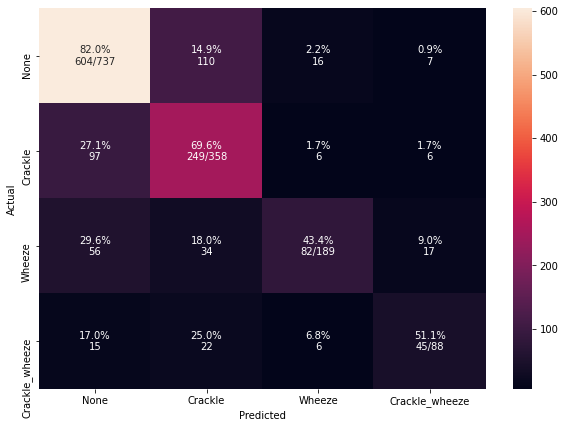

In [85]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
matrix_index = ["None", "Crackle", "Wheeze", "Crackle_wheeze"]

preds = saved_model.predict(X_val)
classpreds = np.argmax(preds, axis=1) # predicted classes 
y_testclass = np.argmax(y_val_cat, axis=1) # true classespo'

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix 
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')

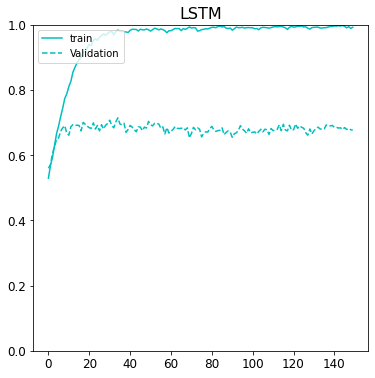

In [9]:
plt.figure(figsize=(6,6))
df = pd.read_csv('logs/log_history_5s_batch22.csv')
plt.title('LSTM', size=16)
plt.plot(df.accuracy, color='c', label='train')
plt.plot(df.val_accuracy, ls='--', color='c', label='Validation')
plt.legend(loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim([0,1.0])
plt.show()

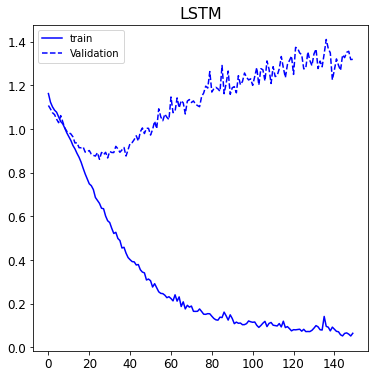

In [8]:
plt.figure(figsize=(6,6))
df = pd.read_csv('logs/log_history_5s_batch22.csv')
plt.title('LSTM', size=16)
plt.plot(df.loss, color='b', label='train')
plt.plot(df.val_loss, ls='--', color='b', label='Validation')
plt.legend(loc='upper left')
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()